Step 1: Load the Data which is prepared from the nuscenes dataset

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Load the Excel file
df_ref = pd.read_excel('Filtered_PCD_Annotations_AB.xlsx')


In [5]:
def get_object_perspective(cam_pose_x, cam_pose_y, box_x, box_y, box_z, box_rotation_w, box_rotation_z):
    """
    Determines the perspective of an object relative to the camera.

    Parameters:
    - box_center: np.array([x, y, z]) → center of the box in world coordinates
    - orientation_quat: Quaternion(w, 0, 0, z) → rotation around Z-axis only
    - cam_position: np.array([x, y, z]) → camera position in world coordinates
    - threshold: angle threshold in radians for classification

    Returns:
    - One of: 'toward', 'away', 'left', 'right'
    """
    threshold=np.pi / 4

    # Camera position in global coordinates
    cam_position = np.array([cam_pose_x, cam_pose_y, 0])  # shape: (3,)

    orientation_quat = Quaternion(
        box_rotation_w,
        0.0, 0.0,
        box_rotation_z
    )
    
    # Compute forward direction of the box (local +X axis rotated by orientation)
    forward_vector = orientation_quat.rotate(np.array([1, 0, 0]))  # shape: (3,)

    # Vector from box to camera
    box_center = [box_x, box_y, box_z]
    to_camera = cam_position - box_center
    to_camera = to_camera / np.linalg.norm(to_camera)

    # Compute angle between forward direction and camera vector
    dot = np.dot(forward_vector[:2], to_camera[:2])  # only XY plane
    angle = np.arccos(np.clip(dot, -1.0, 1.0))  # radians

    # Pad vectors to 3D by adding a zero Z-component
    forward_xy = np.array([forward_vector[0], forward_vector[1], 0])
    to_camera_xy = np.array([to_camera[0], to_camera[1], 0])
    
    # Compute cross product and extract Z-component
    cross_z = np.cross(forward_xy, to_camera_xy)[2]


    # Classify based on angle and cross product
    if angle < threshold:
        return 0 #'toward'
    elif angle > (np.pi - threshold):
        return 1 #'away'
    elif cross_z > 0:
        return 2 #'left'
    else:
        return 3 #'right'

In [56]:
# Load the Excel file

df = df_ref.copy()

selected_columns = [
    'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 
    'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 
    'a_center_x', 'a_center_y', 'a_center_z', 
    'b_center_x', 'b_center_y', 'b_center_z', 
    'a_length', 'a_width', 'a_height', 
    'b_length', 'b_width', 'b_height', 
    'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 
    'b_rotation_w', 'b_rotation_x', 'b_rotation_y', 'b_rotation_z', 
    'a_yaw', 
    'b_yaw',
    'a_category',
    'b_category', 
    'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_vehicle_speed', 'a_yaw_rate',
    'b_brake', 'b_brake_switch', 'b_rear_left_rpm', 'b_rear_right_rpm', 'b_vehicle_speed', 'b_yaw_rate',
    'a_distance', 
    'b_distance', 
    'a_vx', 'a_vy',             
    'b_vx', 'b_vy']
    


df = df[selected_columns]


# Encode box1_category_name
le_category = LabelEncoder()
df['a_category_encoded'] = le_category.fit_transform(df['a_category'])


df['a_box_perspective'] = df.apply(
    lambda row: get_object_perspective(
        row['a_camera_pose_x'],
        row['a_camera_pose_y'],
        row['a_center_x'],
        row['a_center_y'],
        row['a_center_z'],
        row['a_rotation_w'],
        row['a_rotation_z']
    ),
    axis=1
)

df_cleaned_data = df.copy()

df_cleaned_data = df_cleaned_data.drop_duplicates()

# Translation deltas
df_cleaned_data['delta_center_x'] = df_cleaned_data['b_center_x'] - df_cleaned_data['a_center_x']
df_cleaned_data['delta_center_y'] = df_cleaned_data['b_center_y'] - df_cleaned_data['a_center_y']
df_cleaned_data['delta_center_z'] = df_cleaned_data['b_center_z'] - df_cleaned_data['a_center_z']

df_cleaned_data['delta_length'] = df_cleaned_data['b_length'] - df_cleaned_data['a_length']
df_cleaned_data['delta_width'] = df_cleaned_data['b_width'] - df_cleaned_data['a_width']
df_cleaned_data['delta_height'] = df_cleaned_data['b_height'] - df_cleaned_data['a_height']


df_cleaned_data['delta_vehicle_speed'] = df_cleaned_data['b_vehicle_speed'] - df_cleaned_data['a_vehicle_speed']

def compute_delta_quaternion(row):
    q1 = Quaternion([row['a_rotation_w'], 0.0, 0.0, row['a_rotation_z']])
    q2 = Quaternion([row['b_rotation_w'], 0.0, 0.0, row['b_rotation_z']])
    delta_q = q2 * q1.inverse
    return pd.Series({'delta_rotation_w': delta_q.w, 'delta_rotation_x': delta_q.x, 'delta_rotation_y': delta_q.y,'delta_rotation_z': delta_q.z})

df_quat_delta = df_cleaned_data.apply(compute_delta_quaternion, axis=1)
df_cleaned_data = pd.concat([df_cleaned_data, df_quat_delta], axis=1)

# Remove columns with only one unique value
df_cleaned_data = df_cleaned_data.loc[:, df_cleaned_data.nunique() > 1]


df_cleaned_data['a_category_encoded'] = df_cleaned_data['a_category_encoded'].astype('category')

df_cleaned_data = df_cleaned_data.drop(['a_category', 'b_category'], axis=1)

# Select numeric features
non_numeric_cols = df_cleaned_data.select_dtypes(exclude='number').columns.tolist()
df_cleaned_data = pd.get_dummies(df_cleaned_data, columns=non_numeric_cols, drop_first=True)

df_cleaned_data.dtypes

a_camera_pose_x          float64
a_camera_pose_y          float64
b_camera_pose_x          float64
b_camera_pose_y          float64
a_center_x               float64
                          ...   
a_category_encoded_11       bool
a_category_encoded_12       bool
a_category_encoded_13       bool
a_category_encoded_14       bool
a_category_encoded_15       bool
Length: 62, dtype: object

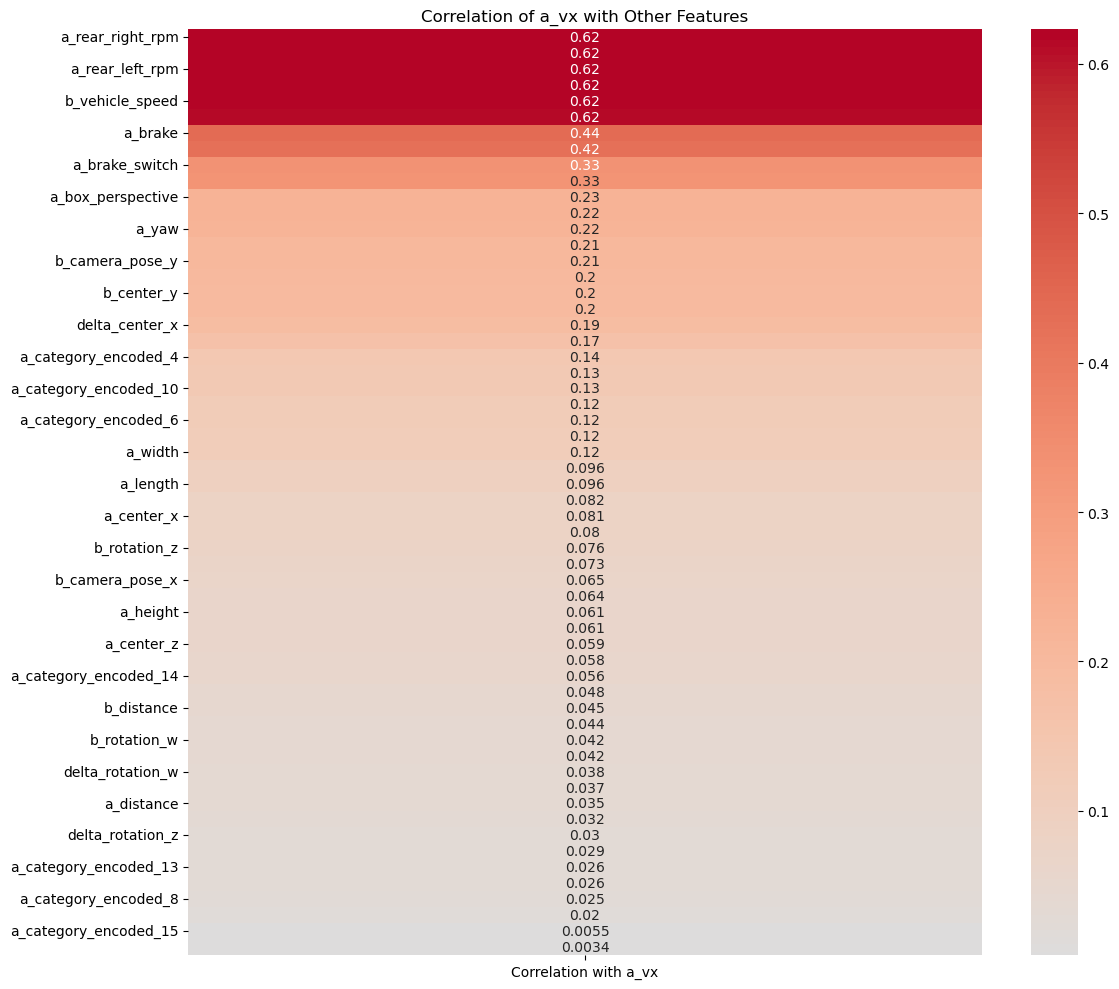

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numeric columns
numeric_df = df_cleaned_data.drop(['b_vx', 'b_vy'], axis=1)

# Compute correlations
corr_vx = numeric_df.corrwith(numeric_df['a_vx']).abs().sort_values(ascending=False)

# Combine into a DataFrame
corr_df = pd.DataFrame({
    'Correlation with a_vx': corr_vx
}).drop(['a_vx', 'a_vy'])  # Drop self-correlations

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of a_vx with Other Features")
plt.tight_layout()
plt.show()

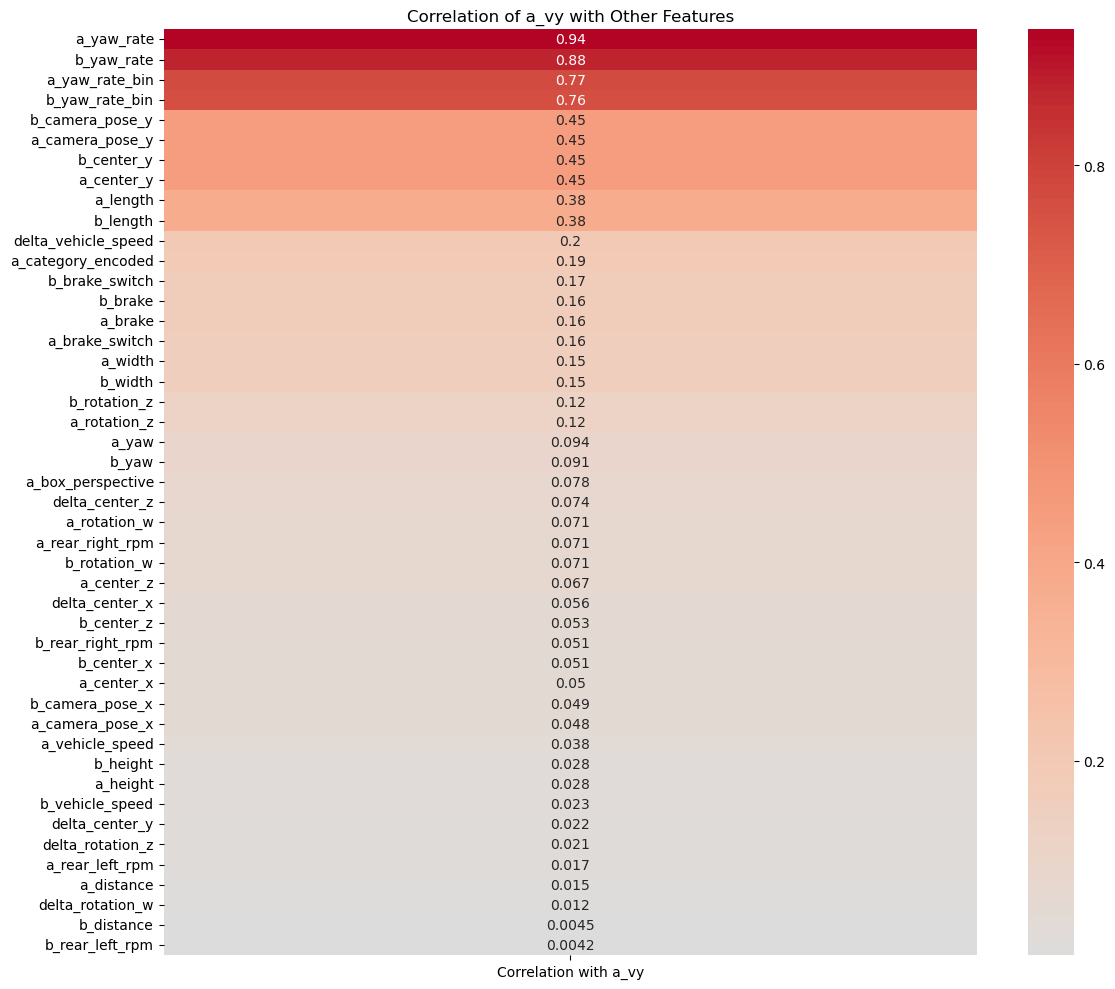

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numeric columns
numeric_df = df_cleaned_data.drop(['b_vx', 'b_vy'], axis=1).select_dtypes(include='number')

# Compute correlations
corr_vy = numeric_df.corrwith(numeric_df['a_vy']).abs().sort_values(ascending=False)

# Combine into a DataFrame
corr_df = pd.DataFrame({
    'Correlation with a_vy': corr_vy
}).drop(['a_vx', 'a_vy'])  # Drop self-correlations

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of a_vy with Other Features")
plt.tight_layout()
plt.show()

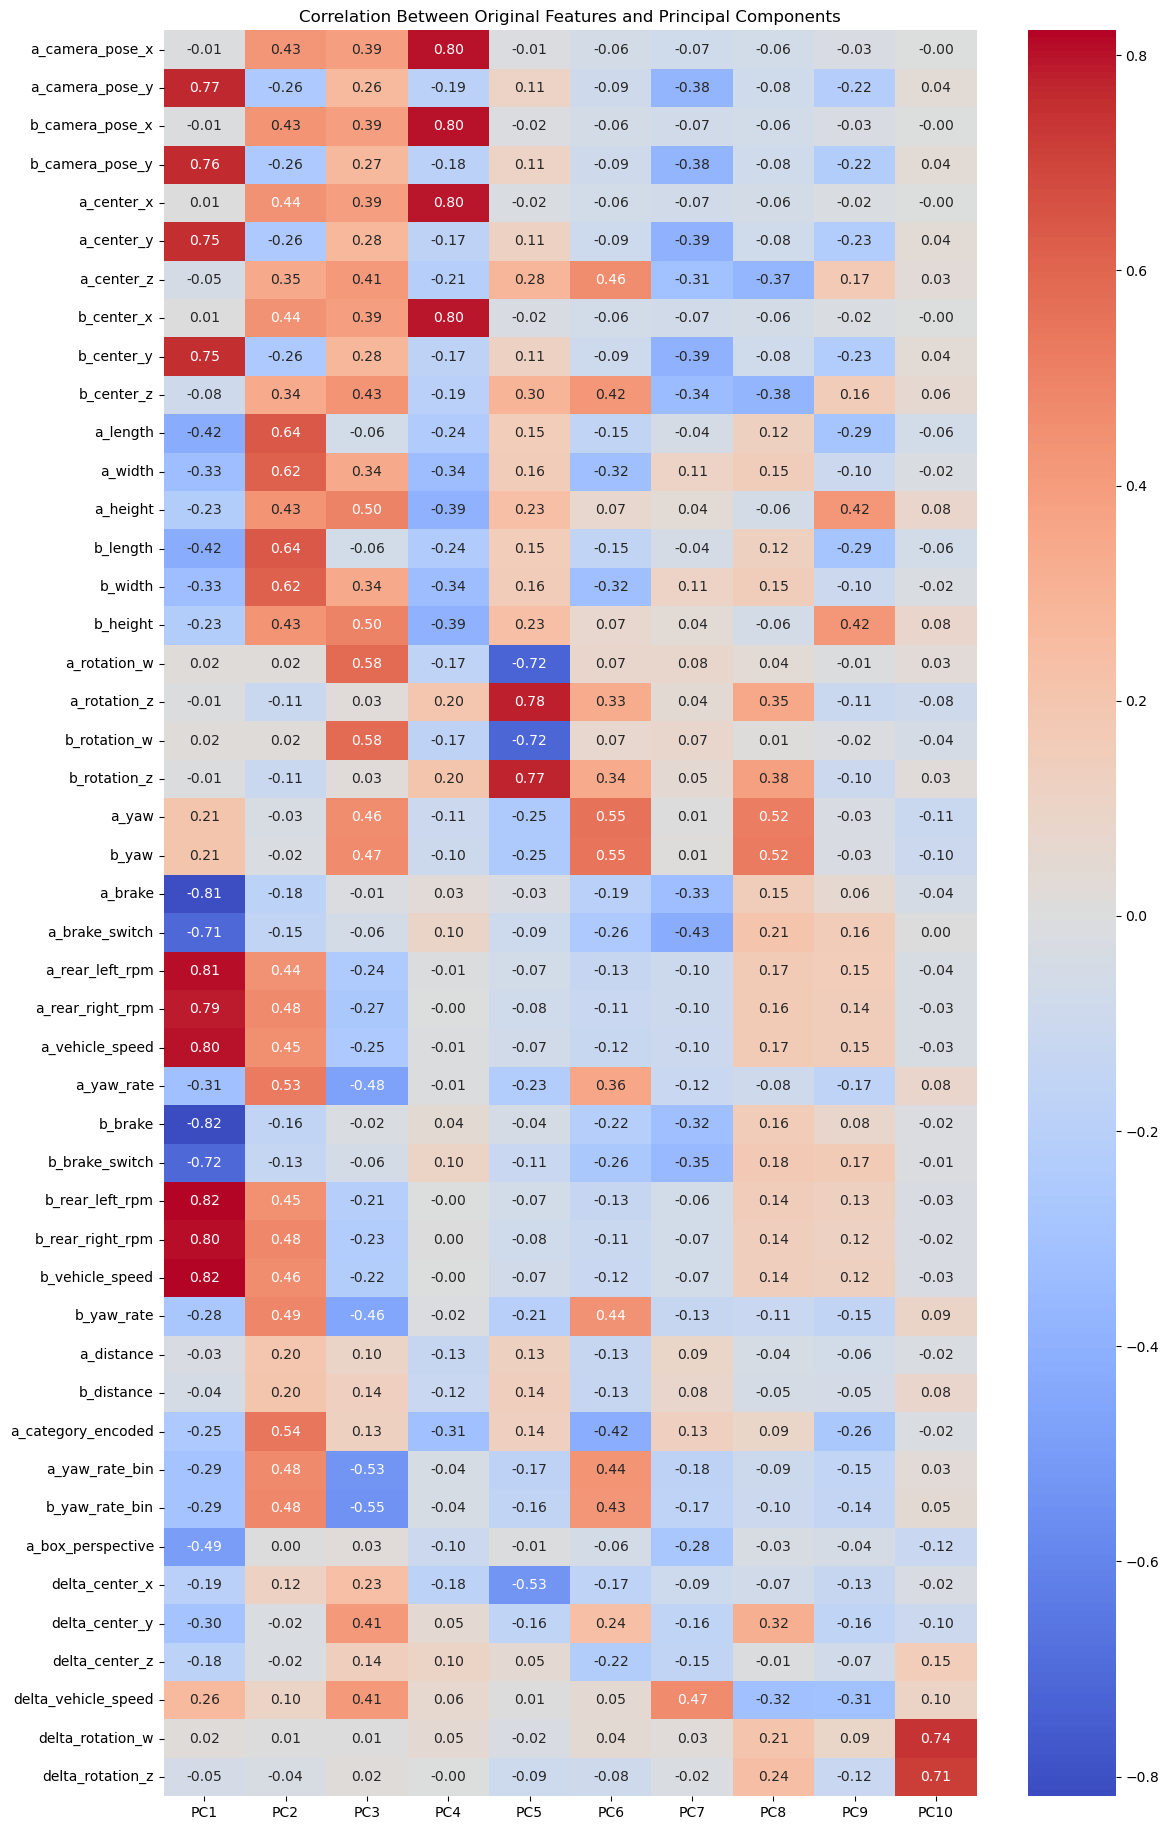

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numeric features
numeric_df = df_cleaned_data.select_dtypes(include='number')

numeric_df = numeric_df.drop(['a_vx', 'a_vy', 'b_vx', 'b_vy'], axis=1)  

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

pca = PCA(n_components=min(10, X_scaled.shape[1]))  # You can adjust n_components
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame of PCA components
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Combine original standardized features and PCA components
combined_df = pd.concat([pd.DataFrame(X_scaled, columns=numeric_df.columns), pca_df], axis=1)

# Compute correlation matrix
corr_matrix = combined_df.corr().loc[numeric_df.columns, pca_df.columns]

plt.figure(figsize=(12, max(8, len(corr_matrix) * 0.4)))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Between Original Features and Principal Components")
plt.tight_layout()
plt.show()